In [1]:
import sys, os, time
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# %load_ext autoreload
# %autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim as O
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader
import gym
from io import BytesIO
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import inspect
import numpy as np
import h5py as hf
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train
from foundation import sim as SIM
#from foundation.util import replicate, Cloner
from scipy import stats
np.set_printoptions(linewidth=120)

In [2]:
def print_info(f):
    print(list(f.keys()), list(f.attrs.keys()))
    for k in f.keys():
        print('{}: {} {}'.format(k, f[k].dtype, f[k].shape))

In [3]:
dataroot = os.environ['FOUNDATION_DATA_DIR']
dataroot

'/is/ei/fleeb/workspace/local_data'

In [4]:
dataset_name = '3dshapes'

In [2]:
dataset = train.get_dataset(dataset_name, dataroot=os.environ['FOUNDATION_DATA_DIR'],)
len(dataset)

480000

In [4]:
test_split = 0.2

In [36]:
util.set_seed(0)
order = torch.randperm(len(dataset))
train_idx = order[int(len(dataset)*test_split):].numpy()
test_idx = order[:int(len(dataset)*test_split)].numpy()

print(train_idx[:5])
print(test_idx[:5])

len(train_idx), len(test_idx)

[165289 176415 256848 370217 306494]
[336044 333544 207733 196425 230539]


(384000, 96000)

In [37]:
path = os.path.join(dataroot, dataset_name, '3dshapes.h5')
path

'/is/ei/fleeb/workspace/local_data/3dshapes/3dshapes.h5'

In [42]:
f = hf.File(path, 'r')
print_info(f)

['images', 'labels'] []
images: uint8 (480000, 64, 64, 3)
labels: float64 (480000, 6)


images: uint8 (480000, 64, 64, 3)
labels: float64 (480000, 6)


In [28]:
images = f['images'][()]
labels = f['labels'][()]
images.shape, labels.shape

((480000, 64, 64, 3), (480000, 6))

In [47]:
os.listdir(os.path.join(dataroot, '3dshapes'))

['3dshapes.h5']

In [44]:
factor_num_values = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10,
                          'scale': 8, 'shape': 4, 'orientation': 15}
factor_order = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']

In [56]:
def save_dataset(target_path, indices):
    print('Dest: {}'.format(target_path))
    print('Name: {}, Size: {}'.format(os.path.basename(target_path), len(indices)))
    with hf.File(target_path, 'w') as tgt:

        tgt.attrs['factor_order'] = [x.encode('ascii', 'replace') for x in factor_order]
        tgt.attrs['factor_sizes'] = [factor_num_values[x] for x in factor_order]

        tgt.create_dataset('labels', data=labels[indices])
        tgt.create_dataset('images', data=images[indices])
        print_info(tgt)

In [57]:
save_dataset(os.path.join(dataroot, dataset_name, '3dshapes_train.h5'), train_idx)

Dest: /is/ei/fleeb/workspace/local_data/3dshapes/3dshapes_train.h5
Name: 3dshapes_train.h5, Size: 384000
['images', 'labels'] ['factor_order', 'factor_sizes']
images: uint8 (384000, 64, 64, 3)
labels: float64 (384000, 6)


In [58]:
save_dataset(os.path.join(dataroot, '3dshapes', '3dshapes_test.h5'), test_idx)

Dest: /is/ei/fleeb/workspace/local_data/3dshapes/3dshapes_test.h5
Name: 3dshapes_test.h5, Size: 96000
['images', 'labels'] ['factor_order', 'factor_sizes']
images: uint8 (96000, 64, 64, 3)
labels: float64 (96000, 6)


In [ ]:
f.close()

In [7]:
dataset = train.get_dataset('3dshapes', dataroot=dataroot, train=False)
len(dataset)

OSError: Unable to open file (unable to open file: name = '/is/ei/fleeb/workspace/local_data/3dshapes/3dshapes.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

torch.Size([3, 64, 64])


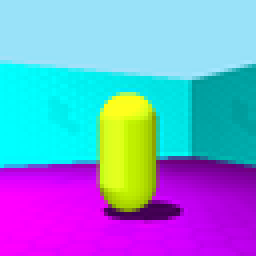

In [55]:
idx = np.random.randint(len(dataset))
x, = dataset[idx]
print(x.shape)
torchvision.transforms.ToPILImage()(x).resize((256, 256))
# plt.imshow(x.permute(1,2,0).cpu().numpy())